In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.compose import TransformedTargetRegressor

In [2]:
import sys
from pathlib import Path

# Get current notebook directory
current_dir = Path.cwd()

# Move up until we find 'src'
for parent in current_dir.parents:
    if parent.name == "src":
        sys.path.append(str(parent))
        break
else:
    raise RuntimeError("Could not find 'src' directory")

from common import utils

In [3]:
ids, X, y = utils.load_cup_data(train=True)

In [4]:
X_dev, X_int_test, y_dev, y_int_test = utils.split_data(X, y, random_state=42)

In [5]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_dev_scaled = x_scaler.fit_transform(X_dev)
X_test_scaled = x_scaler.transform(X_int_test) # Transform test using dev params

In [6]:
model = TransformedTargetRegressor(
    regressor=MLPRegressor(random_state=42, max_iter=2000, early_stopping=True),
    transformer=StandardScaler()
)

In [7]:
# Define Custom MEE Scorer (Greater is better for sklearn, so return negative MEE)
def mean_euclidean_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Euclidean distance per sample: sqrt(sum of squared differences)
    errors = np.sqrt(np.sum((y_true - y_pred) ** 2, axis=1))
    return np.mean(errors)

# greater_is_better=False makes it a loss function (sklearn will minimize it)
mee_scorer = make_scorer(mean_euclidean_error, greater_is_better=False)

In [8]:
param_grid = {
    'regressor__hidden_layer_sizes': [(50,), (20, 20), (40, 30), (50, 20), (70, 40),(100, 50), (30, 20, 10)],
    'regressor__activation': ['relu', 'tanh'],
    'regressor__solver': ['adam', 'sgd', 'lbfgs'],
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1], # L2 Regularization (Required!)
    'regressor__learning_rate_init': [0.001, 0.01],
    'regressor__momentum': [0.5, 0.7, 0.9] # Relevant for sgd
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=kfold,
    scoring=mee_scorer,
    n_jobs=-1,
    return_train_score=False, # Save memory
    verbose=1
)

print("Starting Grid Search...")
# Note: We pass y_dev (raw), the wrapper handles scaling!
grid_search.fit(X_dev_scaled, y_dev)

Starting Grid Search...
Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


/home/debian/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/debian/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/debian/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=MLPRegressor(early_stopping=True,
                                                                         max_iter=2000,
                                                                         random_state=42),
                                                  transformer=StandardScaler()),
             n_jobs=-1,
             param_grid={'regressor__activation': ['relu', 'tanh'],
                         'regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'regressor__hidden_layer_sizes': [(50,), (20, 20),
                                                           (40, 30), (50, 20),
                                                           (70, 40), (100, 50),
                                                           (30, 20, 10)],
                         'regressor__learning_rate_init': [0.001, 0.01],
                         'regressor__momentum': [0.5, 0.7, 0.9],
                         'regressor__solver': ['adam', 'sgd', 'lbfgs']},
             scoring=make_scorer(mean_euclidean_error, greater_is_better=False, response_method='predict'),
             verbose=1)


Best Parameters: {'regressor__activation': 'relu', 'regressor__alpha': 0.01, 'regressor__hidden_layer_sizes': (100, 50), 'regressor__learning_rate_init': 0.01, 'regressor__momentum': 0.5, 'regressor__solver': 'adam'}
Best Validation MEE (Unscaled): 21.6205


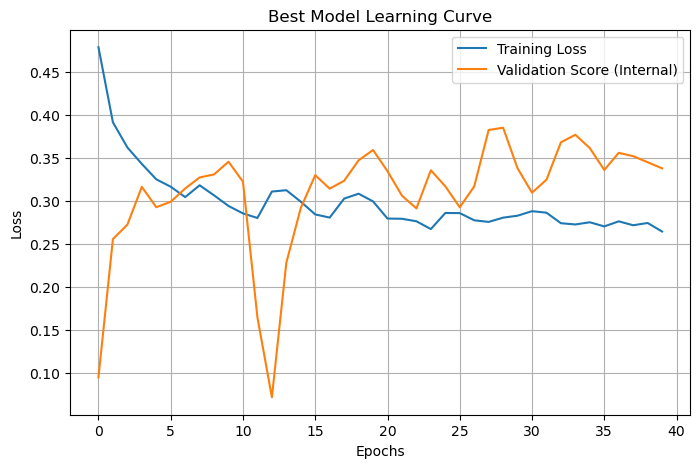

In [9]:
print(f"\nBest Parameters: {grid_search.best_params_}")
# Negate score because we used greater_is_better=False
print(f"Best Validation MEE (Unscaled): {-grid_search.best_score_:.4f}")

# Extract best model (the inner regressor)
best_model_wrapper = grid_search.best_estimator_
best_mlp = best_model_wrapper.regressor_

# PLOT LEARNING CURVE (Required for Report)
plt.figure(figsize=(8, 5))
plt.plot(best_mlp.loss_curve_, label='Training Loss')
if best_mlp.validation_scores_:
    plt.plot(best_mlp.validation_scores_, label='Validation Score (Internal)')
plt.title('Best Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
X_dev_scaled = x_scaler.fit_transform(X_dev)
y_dev_scaled = y_scaler.fit_transform(y_dev)

best_model_wrapper.fit(X_dev_scaled, y_dev_scaled)

TransformedTargetRegressor(regressor=MLPRegressor(alpha=0.01,
                                                  early_stopping=True,
                                                  hidden_layer_sizes=(100, 50),
                                                  learning_rate_init=0.01,
                                                  max_iter=2000, momentum=0.5,
                                                  random_state=42),
                           transformer=StandardScaler())

In [12]:
X_test_scaled = x_scaler.transform(X_int_test)
 # Transform test using dev params

In [13]:
y_pred_test = best_model_wrapper.predict(X_test_scaled)


In [14]:
y_pred = y_scaler.inverse_transform(y_pred_test)

In [15]:
mee=mean_euclidean_error(y_true=y_int_test, y_pred=y_pred)
print(f"Final Test MEE (Unscaled): {mee:.4f}")

Final Test MEE (Unscaled): 26.0259
